In [1]:
# Purpose: Calculating vertical heat flux across 100 m on the West Antarctic
#          continental shelf
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 01. 03. 2023      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
from datetime import datetime # package for printing time in plot                                                                                                       
import matplotlib.pyplot as plt # for matlab-like plotting                                              

# for displaying multiple output in one cell
from IPython.display import display as dp

from dask.distributed import Client
client = Client(n_workers=16)        
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 16
Total threads: 32,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41967,Workers: 16
Dashboard: /proxy/8787/status,Total threads: 32
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:42239,Total threads: 2
Dashboard: /proxy/37439/status,Memory: 11.25 GiB
Nanny: tcp://127.0.0.1:45723,


- ignoring the constants $\rho_0 $, $C_p$ and others for now for easier notation


$\frac{\partial}{\partial z}(w\Theta) = \frac{\partial w}{\partial z} \cdot \Theta + \frac{\partial \Theta}{\partial z} \cdot w$

EN simulation - climatology

$\underbrace{(\overline{w} + w')(\overline{\Theta} + \Theta')}_{EN simulation} - \underbrace{(\overline{w}\overline{\Theta})}_{RYF forcing}$ = 

$\overline{w}\overline{\Theta} + \overline{w}\Theta' + w'\overline{\Theta} + w'\Theta' - \overline{w}\overline{\Theta}$ = 

$\overline{w}\Theta' + w'\overline{\Theta} + w'\Theta'$




In [2]:
%%time
base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean_month.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea']
# ---------------------------------------------------------------------------------- #
sel_lat = [   0,  500]  # [   0,  500] = 81.1°S - 59.5°S                             #
sel_lon = [1299, 2200]  # [1299, 2200] = 150°W - 60°W                                #
# ---------------------------------------------------------------------------------- #
# first get the shelf mask
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000 = above1000.where(above1000 < 1000, drop=True) # remove all values bigger than 1000
above1000 = above1000[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # only select West Antarctica

for e in [1,2]: # loop through the two simulations ENFull and LNFull
    print(exp[e])
    if e == 1: last_output = 985; nr_outputs = 10 # for ENFull, I only have output976-output980
    if e == 2: last_output = 989; nr_outputs = 14

    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = []; t = []; u = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] 

        q.append(i); q[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[1]         
    average_DT = xr.open_mfdataset(q, decode_times = True).average_DT.mean('time').values.astype('int') / 1e9 # average time in seconds per month (the output is saved in ns, that's why /1e9) 

    temp_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).temp[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    temp        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).temp[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    wt_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).wt[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    wt        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).wt[:, :, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    if e == 1: 
        temp_EN = temp; wt_EN = wt
        temp_EN_anom = (temp - temp_clim)
        
    if e == 2: 
        temp_LN = temp; wt_LN = wt
        temp_LN_anom = (temp - temp_clim)
print('----------------------------------')
# Wall time: 30.4 s

01deg_jra55_ryf_ENFull
01deg_jra55_ryf_LNFull
----------------------------------
CPU times: user 12.5 s, sys: 2.64 s, total: 15.2 s
Wall time: 57.7 s


Reference temperature = 5°C
----------------------------
Reference temperature = 0°C
----------------------------
Reference temperature = -5°C
----------------------------
CPU times: user 10.9 s, sys: 936 ms, total: 11.8 s
Wall time: 22.4 s


Text(0.5, 1.1, 'temp_wflux across 100 m (J)\n')

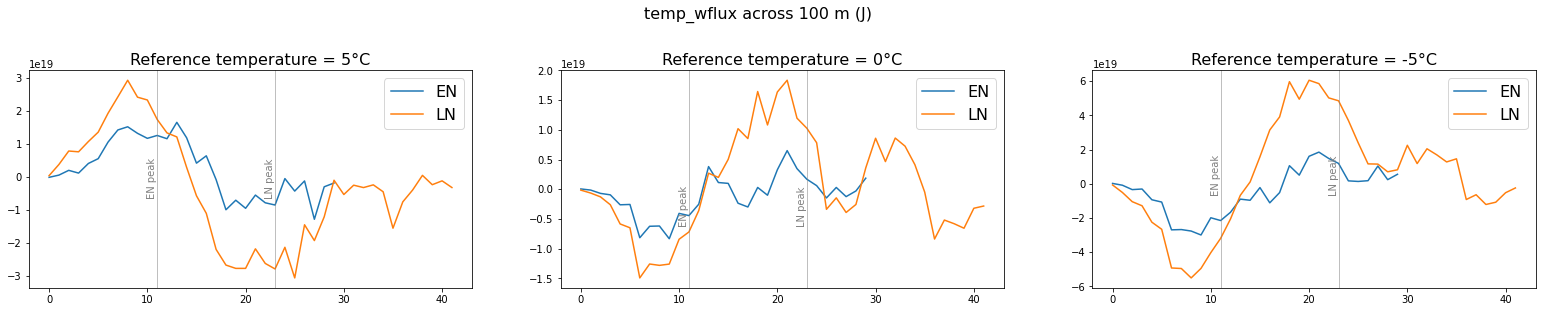

In [6]:
%%time
# get the grid cell area and ocean depth, select West Antarctic shelf region and interpolate to dTdz grid
base_grid = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean'
rho_0 = 1035.0                       # [kg m^{-3}]
C_p   = 3992.10322329649               # [J kg^{-1} K^{-1}]
area_t = xr.open_mfdataset(base_grid+'_grid.nc').area_t[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]


plt.figure(figsize=(27,4))
for f in range(3):
    if f == 0: 
        suffix = 'Reference temperature = 5°C'        
        reference = 268.15; print(suffix)
    if f == 1: 
        suffix = 'Reference temperature = 0°C'
        reference = 273.15; print(suffix)
    if f == 2: 
        suffix = 'Reference temperature = -5°C'
        reference = 278.15; print(suffix)

 
    # here the calculation of the vertical heat flux (kg m-3 * J kg-1 K-1 * m s-1 * K * m2 * s) = (J) --------------------------------------------------- #
    temp_wflux_clim = (rho_0 * C_p * wt_clim[:,23,:,:] * (temp_clim[:,23,:,:]-reference) * area_t * average_DT * above1000).sum(['yt_ocean', 'xt_ocean']) #        
    temp_wflux_EN   = (rho_0 * C_p * wt_EN[:,23,:,:]   * (temp_EN[:,23,:,:]  -reference) * area_t * average_DT * above1000).sum(['yt_ocean', 'xt_ocean']) #    
    temp_wflux_LN   = (rho_0 * C_p * wt_LN[:,23,:,:]   * (temp_LN[:,23,:,:]  -reference) * area_t * average_DT * above1000).sum(['yt_ocean', 'xt_ocean']) #
    # --------------------------------------------------------------------------------------------------------------------------------------------------- #
    
    plt.subplot(1,3,f+1) 
    plt.plot(temp_wflux_EN - temp_wflux_clim, label='EN')
    plt.plot(temp_wflux_LN - temp_wflux_clim, label='LN'); plt.title(suffix, fontsize=16); plt.legend(fontsize=16)
    plt.axvline(11, linewidth=.5, c='grey'); plt.text(10, -6e18, 'EN peak', rotation=90, c='grey', ha='left')
    plt.axvline(23, linewidth=.5, c='grey'); plt.text(22, -6e18, 'LN peak', rotation=90, c='grey', ha='left')
    print('----------------------------')
    
plt.suptitle('temp_wflux across 100 m (J)\n', fontsize=16, y = 1.1)
# Wall time: 21.8 s

Now calculating the anomalies first

$\underbrace{\overline{\Theta} + \Theta'}_{EN simulation} - \underbrace{\overline{\Theta}}_{RYF forcing} = \Theta'$

Reference temperature = 5°C
----------------------------
Reference temperature = 0°C
----------------------------
Reference temperature = -5°C
----------------------------
CPU times: user 11.5 s, sys: 1.1 s, total: 12.6 s
Wall time: 26.6 s


Text(0.5, 1.1, 'temp_wflux across 100 m when anoms created first (J)\n')

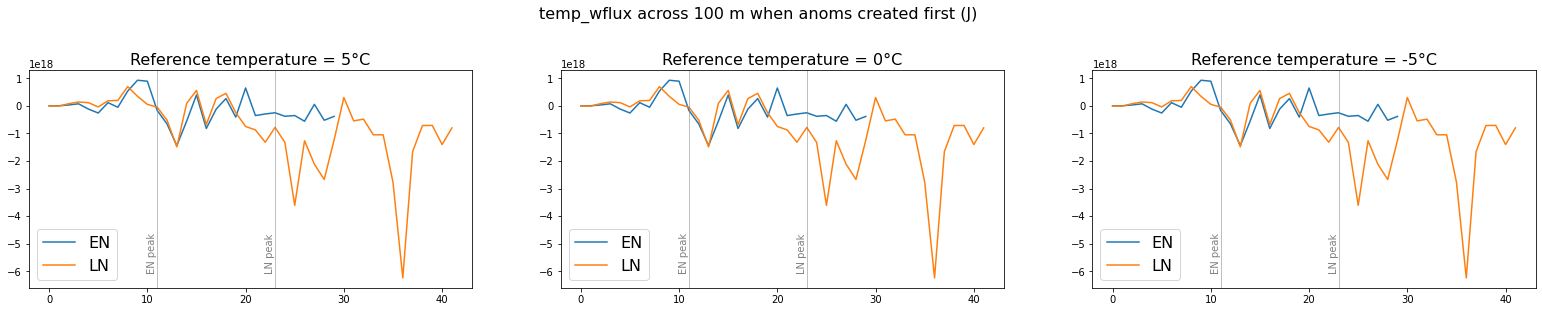

In [4]:
%%time
plt.figure(figsize=(27,4))
for f in range(3):
    if f == 0: 
        suffix = 'Reference temperature = 5°C'        
        reference = 268.15; print(suffix)
    if f == 1: 
        suffix = 'Reference temperature = 0°C'
        reference = 273.15; print(suffix)
    if f == 2: 
        suffix = 'Reference temperature = -5°C'
        reference = 278.15; print(suffix)
        
    # anomaly calculation here first
    wt_EN_anom = wt_EN[:,23,:,:] - wt_clim[:,23,:,:]
    wt_LN_anom = wt_LN[:,23,:,:] - wt_clim[:,23,:,:]

    temp_EN_anom = (temp_EN[:,23,:,:]-reference) - (temp_clim[:,23,:,:]-reference)
    temp_LN_anom = (temp_LN[:,23,:,:]-reference) - (temp_clim[:,23,:,:]-reference)
    

    # here the calculation of the vertical heat flux (kg m-3 * J kg-1 K-1 * m s-1 * K * m2 * s) = (J) --------------------------------------------------- #
    temp_wflux_EN   = (rho_0 * C_p * wt_EN_anom * temp_EN_anom * area_t * average_DT * above1000).sum(['yt_ocean', 'xt_ocean']) #    
    temp_wflux_LN   = (rho_0 * C_p * wt_LN_anom * temp_LN_anom * area_t * average_DT * above1000).sum(['yt_ocean', 'xt_ocean']) #
    # --------------------------------------------------------------------------------------------------------------------------------------------------- #
    
    plt.subplot(1,3,f+1) 
    plt.plot(temp_wflux_EN, label='EN')
    plt.plot(temp_wflux_LN, label='LN'); plt.title(suffix, fontsize=16); plt.legend(fontsize=16)
    plt.axvline(11, linewidth=.5, c='grey'); plt.text(10, -6e18, 'EN peak', rotation=90, c='grey', ha='left')
    plt.axvline(23, linewidth=.5, c='grey'); plt.text(22, -6e18, 'LN peak', rotation=90, c='grey', ha='left')
    print('----------------------------')
    
plt.suptitle('temp_wflux across 100 m when anoms created first (J)\n', fontsize=16, y = 1.1)
# Wall time: 2min 39s
# Wall time: 39 s for one iteration and one reference temperature

In [5]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #